In [171]:
######################### This version is meant to be a clone or Dr.Orlandi's version. Using his psych curve etc. goal is to clone behaviour. Will Implement objects.
######################### And then modify from there 
#gonna work in radians

In [172]:
#imports
import numpy as np
import sklearn.model_selection as sk
import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.keras.layers import Input
import tensorflow.keras.backend as kb
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.io as sio
import random
from numba import jit

In [173]:
################### GLOBAL VARIABLES
#NUMANGLES = 8 #how many orientations each side can take
#MAXPROB = .95

#TRIALSPERANGLE = 10000

#NUMDIFFBINS = 3 #should be about (numAngles-2)/2


#ANGLEMAX = np.pi/2
#ANGLEMIN = -np.pi/2

#MAX_EPOCHS = 100 # Total epochs
#BATCH_SIZE = 20000 # Trials per batch

#NOCHOICEVAL = 1
#LEFTCHOICEVAL = 0  #Value output when choosing left bar
#RIGHTCHOICEVAL = 2 #Value output when choosing right bar

#UNITS = 256 # Number of neurons in the dense layer
#OUTPUT_SIZE = 3 # Number of output states
#INPUT_DIMENSION = 3 #dimension of input. 

#ANGLE_DIMENSION = 2

#STIMULUSDURATION = 1.5 #length of the stimulus (seconds)
#PRESTIMULUSDURATION = 1 #length of the pre stimulus (seconds)

#ONECHOICE = False #whether makes one choice and sticks or changes mind

#FRAMERATE = 10 #(hz)

#TOTALFRAMES = int(FRAMERATE*(STIMULUSDURATION + PRESTIMULUSDURATION)) #total number of frames

#LASTFRAME = TOTALFRAMES - 1 #Index of last frame

#ATTENTION_LEVELS = [0,1]  # Binary attention, currently -> low (0) or high (1)

#PRESTIMULUSFRAME = int(PRESTIMULUSDURATION * FRAMERATE) - 1
#STIMULUS_FRAME = PRESTIMULUSFRAME + 1
#################################################

In [174]:
class timeSeries:
    '''Class whose objects are times series'''
    
    def __init__(self, series):
        '''Initialization method. Stores an input list'''
        self.tSeries = series

In [175]:
class aTrial:
    '''Objects of this class represent a single trial'''
    
    def __init__(self, inputSeries, outputSeries, decider, info):
        '''Initialization method. Stores information for one trial
        input Series (timeSeries) is the input time series for a trial. 
        output series (timeSeries) is the output time series for a trial
        info (trialInfo) is information about the trial. '''
        self.inputSeries = inputSeries 
        self.outputSeries = outputSeries
        self.decisionAgent = decider
        self.info = info

In [176]:
class anglePair:
    '''Class whose objects are pairs of angles'''

    def __init__(self, angle1, angle2):
        '''Initialization method stores 2 input angles to the instance'''
        self.angle1 = angle1
        self.angle2 = angle2

In [177]:
class trialInfo:
    '''Class whose objects represent information about a trial'''

    def __init__(self, angSep,pCertain,correctCh, difficultyBin, difficulty):
        #The angle seperation
        self.angSep = angSep
        
        #The probability of certainty
        self.pCertain = pCertain

        #The correct choice
        self.correctCh = correctCh

        #The difficulty bin the trial falls into
        self.difficultyBin = difficultyBin

        #The difficulty of the trial
        self.difficulty = difficulty


In [178]:
class frameInfo:
    '''Class whose objects represent information about a frame in a trial'''

    def __init__(self, angSep,pCertain,correctCh, difficulty):
        #The angle seperation
        self.angSep = angSep

        #The probability of certainty
        self.pCertain = pCertain

        #The correct choice
        self.correctCh = correctCh

        #The difficulty
        self.difficulty = difficulty


In [179]:
class decisionMaker:
    '''Class that represents the agent making the decision'''

    def __init__(self, attention):
        '''initialization method sets the attention level of the instance'''
        self.attention = attention

    def _sameSign(self, angles):
        '''given a list of two angles the method return True if the angles have same sign. False if the angles have opposite sign'''
        angle1 = angles[0]
        angle2 = angles[1]
        return not abs(angle1 + angle2) < abs(angle1)+abs(angle2)

    def _difficulty(self, angles, LOWATTVAL, HIGHATTVAL):
        '''Given two angles this function returns a difficulty from 0 - 1; 1 being hardest; 0 is easiest'''

        #Variable representing whether or not the angles are the same sign. (Point to the same side ([/ /]->same side) vs ([\ /]->opposite side)
        sameSign = self._sameSign(angles)

        #Find the magnitude of the difference of the angles
        difference = abs( abs(angles[0]) - abs(angles[1]) )

        #slope parameter for steepness of difficulty curve (a function of angle separation)
        beta = 0.05
        #Set the y intercept of the inverse hyperbolic tangent
        if self.attention == LOWATTVAL:
            alpha = .28 #Alpha is the value of y intercept of the tanh. Also the value of the difficulty of an infinite angle separation. Make it higher for low attention
        elif self.attention == HIGHATTVAL:
            alpha = 0.1 #Make it lower for high attention

        #offset to shift the graph so at x = 0 arctanh(g(x)) is alpha
        offset = np.arctanh( 2*alpha - 1 )/beta 

        #Scaling Parameter. relates to d(difficulty)/d(angle separation)
        f = .1
        if not sameSign: 
            #the angles are not the same side so add a bias to the difficulty
            y = 0  #Parameter that changes difficulty for a given angle separation depending on if they have the same sign [/ /] VS [\ /]
            
            #Shrink f by y 
            f = f - y*f 
        
        #scale it so small differences are large value and big differences are small. Map 0 to inf and inf to zero.                 
        x = 1/(f*difference**2) 

        #Calculate and return difficulty
        dif = 1/2 * ( np.tanh( beta * (x + offset) ) + 1 )

        return dif

    def correctChoice(self, angles, LEFTCHOICEVAL, RIGHTCHOICEVAL):
        '''input 2 angles return the smaller angle corresponding to more vertical orientation
        Angle 1 is left angle 2 is right. Returns -1 for Left 1 for right
        if they are equal error is thrown because currently only training on non equal angles
        '''
        
        angle1 = angles[0]
        angle2 = angles[1]

        if abs(angle1) < abs(angle2):
            #The left bar is oriented more vertically
            return LEFTCHOICEVAL        
            
        elif abs(angle2) < abs(angle1):
            #The right bar is oriented more vertically
            return RIGHTCHOICEVAL       
        
        else:
            #throw error if angles are equal
            print("WEHAVEANERROR")
            return "Error. Not expecting equal angles" 
        
    def trainedChoice(self, angles, LOWATTVAL, HIGHATTVAL, LEFTCHOICEVAL, RIGHTCHOICEVAL, MAXPROB):
        '''Input two angles returns the choice the mouse makes'''

        #store the difficulty
        difficulty = self._difficulty(angles, LOWATTVAL, HIGHATTVAL)
        
        #Calculate the probability that the decision maker is certain
        pCertain = self._probablilityCertain(difficulty)

        #Check if the probCertain is larger than the maximum allowed certainty
        if pCertain > MAXPROB:
            #If probability certain is larger than the max allowed, then set it to the max
            pCertain = MAXPROB
        
        #Calculate the correct choice. (more vertically oriented)    
        cor = self.correctChoice(angles, LEFTCHOICEVAL, RIGHTCHOICEVAL)
        
        angDif = ( abs(angles[0]) - abs(angles[1]) ) #angle difference
        
        info = frameInfo(angDif, pCertain, cor, difficulty)
       
        #Generate a random number in [0,1) and use it to determin whether the decision maker is certain or not
        n = random.random()

        if n < pCertain: #they are certain
            #The decision maker is certain so return the correct answer
            return cor, info
            
        else:#not certain then it is a guess
            #generate a random number in [0,1) to decide which side the decision maker guesses
            g = np.random.random()
            if g < .5:
                #return the correct choice
                return cor, info
            else:
                #return the other choice
                if cor == RIGHTCHOICEVAL:
                    return LEFTCHOICEVAL, info
                else:
                    return RIGHTCHOICEVAL, info
                
    def _probablilityCertain(self, difficulty):
        '''return the probability of being certain as a function of difficulty'''
        #difficulty goes from 1 to 0. this flips it and maps a high difficulty to a low probability of being chosen
        p = -difficulty + 1
        return p

In [180]:
class timeSeriesCreationMachine:
    '''This class has objects that are machines to create time series. it will have configuration options and a method that spits out time series'''
    
    def addNoise(self, inputTimeSeries, NUMANGLES):
        '''adds noise to an input timeSeries'''
        #Parameter that scales the temporal noise
        temporalNoiseScale = (NUMANGLES/np.pi) * 15
       
        #The number of frames
        num_frames = inputTimeSeries.tSeries.shape[0]

        # Generate random noise for each frame
        noise_0 = np.random.randn(num_frames) / temporalNoiseScale
        noise_1 = np.random.randn(num_frames) / temporalNoiseScale

        # Apply noise to the corresponding frames
        inputTimeSeries.tSeries[:, 0] += noise_0
        inputTimeSeries.tSeries[:, 1] += noise_1

        return inputTimeSeries

    def createInputTimeSeries(self, anglePair, NUMANGLES,TOTALFRAMES, ANGLE_DIMENSION, STIMULUS_FRAME):                                                                                                                    
        '''Input: ([angle1, angle2], attention)
           Output: timeSeries corresponding to input to network

           generates an input time series for one trial with angles given by angle pair
             '''
        
        #initialize the list to store the input time series
        inputTimeSeries = timeSeries(np.zeros((TOTALFRAMES, ANGLE_DIMENSION)).astype(np.float32)) 

        #Add the angles to the series
        inputTimeSeries.tSeries[STIMULUS_FRAME:, 0] = anglePair[0]
        inputTimeSeries.tSeries[STIMULUS_FRAME:, 1] = anglePair[1]

        #Add noise to the series
        inputTimeSeries = self.addNoise(inputTimeSeries, NUMANGLES)

        #return the time series
        return inputTimeSeries
    
    def findBin(self, domainStart, domainStop, numBins, value):
        '''domain start is the start of the interval the histogram is defined on.
         domain end is the end of the interval. If it was a histogram of adult heights then start would be lowest height and stop be largest height
         numBins is the number of bins there are
          value is the value you want to determine which bin it is in.
           if my interval was from 0 to 1 and i had two bins then 0.2 would be in bin 0.  '''
        #dx is width of bins
        dx = abs(domainStop - domainStart)/numBins
        bin = int(value / dx)
        return bin
                    
    def createOutputTimeSeries(self, inputTimeSeries, oneChoice, decisionAgent,ANGLEMAX, LOWATTVAL, HIGHATTVAL, TOTALFRAMES, STIMULUSDURATION, FRAMERATE, PRESTIMULUSFRAME,NOCHOICEVAL,LEFTCHOICEVAL, RIGHTCHOICEVAL, MAXPROB, STIMULUS_FRAME, NUMDIFFBINS ):
        '''Input: the input time series, attention level, bool that determines if decisionMaker makes multiple choices
           Output: An output time series that is meant to be the desired output of the network when recieving the input time series'''
      
        #Initialize the response time series
        outputTimeSeries = timeSeries(np.full((TOTALFRAMES), np.nan)) 

        infoLength = int(round(STIMULUSDURATION*FRAMERATE,0))

        #angSep is abs(ang1) - abs(ang2)
        angSep = np.zeros(infoLength)
        pCert = np.zeros(infoLength)
        correctCh = np.zeros(infoLength)
        difficulty = np.zeros(infoLength)
  
        #Go through frames and create output time series
        for frame in range(TOTALFRAMES): 
            if frame < PRESTIMULUSFRAME: 
                #The output for preStim frames is nan
                outputTimeSeries.tSeries[frame] = np.nan
            elif frame == PRESTIMULUSFRAME:
                #At the preStim frame we want noChoice to be the output
                outputTimeSeries.tSeries[frame] = NOCHOICEVAL
            elif frame == STIMULUS_FRAME:
                #On stim frame make a first decision 
                firstTrainedChoice, frameInformation = decisionAgent.trainedChoice(inputTimeSeries.tSeries[frame], LOWATTVAL, HIGHATTVAL, LEFTCHOICEVAL, RIGHTCHOICEVAL, MAXPROB)
                outputTimeSeries.tSeries[frame] = firstTrainedChoice
                angSep[frame - STIMULUS_FRAME] = frameInformation.angSep
                pCert[frame - STIMULUS_FRAME] = frameInformation.pCertain 
                correctCh[frame - STIMULUS_FRAME] = frameInformation.correctCh
                difficulty[frame - STIMULUS_FRAME] = frameInformation.difficulty
              
            elif oneChoice == True:
                #We stick with the first decision made at stim presentation
                #No new choices made. each frame we stick with decision made on stim frame
                outputTimeSeries.tSeries[frame] = firstTrainedChoice
                angSep[frame - STIMULUS_FRAME] = frameInformation.angSep
                pCert[frame - STIMULUS_FRAME] = frameInformation.pCertain
                correctCh[frame - STIMULUS_FRAME] = frameInformation.correctCh
                difficulty[frame - STIMULUS_FRAME] = frameInformation.difficulty

            else:
                #continue making choices each frame
                trainedChoice, frameInformation = decisionAgent.trainedChoice(inputTimeSeries.tSeries[frame], LOWATTVAL, HIGHATTVAL, LEFTCHOICEVAL, RIGHTCHOICEVAL, MAXPROB)
                outputTimeSeries.tSeries[frame] = trainedChoice
                angSep[frame - STIMULUS_FRAME] = frameInformation.angSep
                pCert[frame - STIMULUS_FRAME] = frameInformation.pCertain
                correctCh[frame - STIMULUS_FRAME] = frameInformation.correctCh
                difficulty[frame - STIMULUS_FRAME] = frameInformation.difficulty

        ####AVERAGE INFO
        angSep = np.average(angSep)
        pCert = np.average(pCert)
        correctCh = np.average(correctCh)
        difficulty = np.average(difficulty)
       
        #Value that is used to determine the difficulty of the trial. Absolute value because we care about difficulty so -pi/5 == pi/5 in terms of difficulty
        val = abs(angSep)

        #Determine the difficulty of the trial
        difficultyBin = self.findBin(0, ANGLEMAX, NUMDIFFBINS, val)

        #Store the trial info
        info = trialInfo(angSep,pCert,correctCh, difficultyBin, difficulty)


        return outputTimeSeries, info                                                                                                          

In [181]:
class ensembleCreator:
    '''uses the timeSeriesCreator class to create an ensemble of iteration time series'''

    def addNoise(self, anglePairs, NUMANGLES):
        '''input a list of left angles and list of right angles and noise is added to them and returned is an array of angle pairs for the ensemble'''
        #extract the left and right angles 
        leftAngles = anglePairs[:, 0]
        rightAngles = anglePairs[:, 1]

        #Variable that scales the noise
        noiseScale = (NUMANGLES/np.pi) * 30

        #Add noise to the left and right angles 
        leftAngles += np.random.randn(len(leftAngles)) / noiseScale
        rightAngles += np.random.randn(len(rightAngles)) / noiseScale

        #Reshape the two 1d arrays into one 2d array
        anglePairs = np.column_stack((leftAngles, rightAngles))

        return anglePairs

    def filterSameAngles(self, angle_grid):
        '''input a grid of angles and return list of left and right angles with the abs(angleLeft)!=abs(angleRight)
        filter outt all the angles with same verticallity'''

        #number of decimals to be rounded to when filtering out equal verticality. Due to special operations floating points are not consistent so this is necessary.
        decimals = 2

        #extract the angles
        leftAngles = angle_grid[0].ravel()
        rightAngles = angle_grid[1].ravel()

        #Create the mask
        mask = (np.round(leftAngles, decimals) != np.round(rightAngles, decimals)) & (-np.round(leftAngles, decimals) != np.round(rightAngles, decimals))
       
        #apply the mask
        leftAngles = leftAngles[mask]
        rightAngles = rightAngles[mask]

        #Reshape the two 1d arrays into one 2d array
        anglePairs = np.column_stack((leftAngles, rightAngles)) 

        return anglePairs


    def genAngles(self, ANGLEMAX, ANGLEMIN, NUMANGLES):
        '''This function returns all the angle pairs for one ensemble of trials (One attention level)'''
        #Generate a list of valid angles for one side
        angleList = np.linspace(ANGLEMAX, ANGLEMIN, NUMANGLES)

        #Create a grid of all angle combinations
        angle_grid = np.meshgrid(angleList, angleList)

        #Filter out angles with same verticallity
        anglePairs = self.filterSameAngles(angle_grid)

        #Add noise to the angles
        anglePairs = self.addNoise(anglePairs, NUMANGLES)
        
        #Randomize the order
        np.random.shuffle(anglePairs)

        return anglePairs
    
    
    def generateEnsemble(self, attention, ANGLEMAX, ANGLEMIN, NUMANGLES, ONECHOICE, LOWATTVAL, HIGHATTVAL, TOTALFRAMES, STIMULUSDURATION, FRAMERATE, PRESTIMULUSFRAME,NOCHOICEVAL,LEFTCHOICEVAL, RIGHTCHOICEVAL, MAXPROB, STIMULUS_FRAME, NUMDIFFBINS, ANGLE_DIMENSION):
        '''Input: An attention level, numBins is number of difficulty levels
           Output: An ensemble of input and output time series corresponding to the input attention level. 
           (The input is what is fed into the network and the output is the desired network response)'''
        
        #generate the angles for the ensemble of trials
        anglePairs = self.genAngles(ANGLEMAX, ANGLEMIN, NUMANGLES)

        #Determine the number of trials 
        numberTrials = len(anglePairs)

        #Instantiate a timeSeriesCreator
        timeSeriesCreator = timeSeriesCreationMachine()

        #Initialize a list to store this ensembles trials
        trialList = np.zeros(numberTrials).astype(aTrial)

        #Go through the trials and for each trial create an input and output time series
        for trial in range(numberTrials):
            #create input time series
            inputTimeSer = timeSeriesCreator.createInputTimeSeries(anglePairs[trial], NUMANGLES,TOTALFRAMES, ANGLE_DIMENSION, STIMULUS_FRAME) 
            
            #initialize a decisionMaker
            decisionAgent = decisionMaker(attention)

            #create output time series
            outputTimeSer, informat = timeSeriesCreator.createOutputTimeSeries(inputTimeSer ,ONECHOICE, decisionAgent,ANGLEMAX, LOWATTVAL, HIGHATTVAL, TOTALFRAMES, STIMULUSDURATION, FRAMERATE, PRESTIMULUSFRAME,NOCHOICEVAL,LEFTCHOICEVAL, RIGHTCHOICEVAL, MAXPROB, STIMULUS_FRAME, NUMDIFFBINS )

            #creare the trial object for this trial
            trialHere = aTrial(inputTimeSer, outputTimeSer, decisionAgent, informat)
            
            #store the trial data
            trialList[trial] = trialHere

        return trialList
    
    def generateEnsembles(self, attentionList, TRIALSPERANGLE, ANGLEMAX, ANGLEMIN, NUMANGLES, ONECHOICE, LOWATTVAL, HIGHATTVAL, TOTALFRAMES, STIMULUSDURATION, FRAMERATE, PRESTIMULUSFRAME,NOCHOICEVAL,LEFTCHOICEVAL, RIGHTCHOICEVAL, MAXPROB, STIMULUS_FRAME, NUMDIFFBINS, ANGLE_DIMENSION):
        '''Input: a list of attention levels
           Output: an ensemble of trials at each attention level'''
        
        #Boolean  representing if it is the first attention level. If first then a new list needs to be created. else the existing list should be appended to
        first = True

        #repeat each trial TRIALSPERANGLE times
        for _ in range(TRIALSPERANGLE):

            #Counter variable
            c = 0

            #for each attention level create an ensemble of trials
            for attentionLevel in attentionList:

                #Generate ensemble of trials for this attention level
                trialsData = self.generateEnsemble(attentionLevel,ANGLEMIN, ANGLEMAX, NUMANGLES, ONECHOICE, LOWATTVAL, HIGHATTVAL, TOTALFRAMES, STIMULUSDURATION, FRAMERATE, PRESTIMULUSFRAME,NOCHOICEVAL,LEFTCHOICEVAL, RIGHTCHOICEVAL, MAXPROB, STIMULUS_FRAME, NUMDIFFBINS, ANGLE_DIMENSION)

                #The first time running the list needs to be created
                if first:

                    #Create the list
                    allTrialsData = trialsData

                    #Set first to false
                    first = False

                else:

                    #It is not the first time running so the list exists and it can be appended
                    allTrialsData =  np.concatenate((allTrialsData, trialsData), axis = 0)
                
                #increment the counter
                c +=1

        #Shuffle the list
        np.random.shuffle(allTrialsData)
        
        return allTrialsData

In [182]:
class netModel:

    def __init__(self):
        '''initialization method. Initializes instance attributes'''

        #an array of all trials in data set
        self.trialsData = np.nan

        #an array of timeSeries of input to the network for training
        self.inputTrainingData = np.nan

        #an array of timeSeries of input to the network for testing
        self.inputTestData = np.nan

        #an array of timeSeries of desired network output for training
        self.responseTrainingData = np.nan

        #an array of timeSeries of desired network output for testing
        self.responseTestData = np.nan

        #an array of difficulty bins for the testing trials
        self.testDifData = np.nan

        #an array of difficulty bins for the training trials
        self.trainDifData = np.nan

        #an array of correct choices for the testing trials
        self.testCorChData = np.nan

        #an array of correct choices for the training trials
        self.trainCorChData = np.nan

        #an array of output from trained network when inputting inputTrainingData
        self.testResponse = np.nan

        #the model itself
        self.model = np.nan

        #boolean representing whether the model has been trained or not.
        #used to give an error if requesting test response before network is trained 
        self.isFit = False

    def _parameter_custom_loss(s, PRESTIMULUSFRAME, LASTFRAME):
        def _custom_loss(y_actual,y_pred): 
            '''calculates the loss using the frame immediately before stimulus and last frame of time series
            The frame before stim is to set p left and p right = 0'''

            #Train it to have zero probability of left or right at pre stim frame
            l1 = kb.sparse_categorical_crossentropy(y_actual[:, PRESTIMULUSFRAME], y_pred[:, PRESTIMULUSFRAME])

            #train it to make the correct choice at the end
            l2 = kb.sparse_categorical_crossentropy(y_actual[:, LASTFRAME], y_pred[:, LASTFRAME])
            custom_loss = l1 + l2
            return custom_loss
        return _custom_loss

    def _parameter_custom_cat(s, LASTFRAME):
        def _custom_cat(y_actual,y_pred):
            '''Checks the accuracy of the final predicted output and compares it to the desired output'''
            l2 = tf.keras.metrics.sparse_categorical_accuracy(y_actual[:, LASTFRAME], y_pred[:, LASTFRAME])
            custom_cat = l2
            return custom_cat
        return _custom_cat
    
    def genData(self, ATTENTION_LEVELS, TRIALSPERANGLE, ANGLEMIN, ANGLEMAX, NUMANGLES, ONECHOICE, LOWATTVAL, HIGHATTVAL, TOTALFRAMES, STIMULUSDURATION, FRAMERATE, PRESTIMULUSFRAME,NOCHOICEVAL,LEFTCHOICEVAL, RIGHTCHOICEVAL, MAXPROB, STIMULUS_FRAME, NUMDIFFBINS, ANGLE_DIMENSION):
        '''generates and stores the training/testing data for the network'''
        
        #Instantiate an ensemble creator object
        ensembleGen = ensembleCreator()
        
        #Generate an ensemble of trials for each attention level in the attention list and store the trials in trialsData
        self.trialsData = ensembleGen.generateEnsembles(ATTENTION_LEVELS, TRIALSPERANGLE, ANGLEMIN, ANGLEMAX, NUMANGLES, ONECHOICE, LOWATTVAL, HIGHATTVAL, TOTALFRAMES, STIMULUSDURATION, FRAMERATE, PRESTIMULUSFRAME,NOCHOICEVAL,LEFTCHOICEVAL, RIGHTCHOICEVAL, MAXPROB, STIMULUS_FRAME, NUMDIFFBINS, ANGLE_DIMENSION)

    def addAttention(self, trial):
        '''adds attention to the trials input time series
        the time series was two dimensional with second axis having lenght of two [left angle, right angle]
        now it is [left angle, right angle, attention]
        
        #Maybe should just add attention when creating input time series idk...# '''

        #generate empty list to store attention series
        att = np.zeros(len(trial.inputSeries.tSeries))

        #Add the data to the empty series
        att += trial.decisionAgent.attention

        #Add the attention series to the trials time series
        trial.inputSeries.tSeries= np.hstack((trial.inputSeries.tSeries, np.expand_dims(att, axis=1)))

        return trial
        
    def splitData(self, TOTALFRAMES,INPUT_DIMENSION):
        '''splits and stores the data into training and test sets'''
       
        if np.isnan(self.trialsData[0].inputSeries.tSeries).any(): #MAKE BETTER
            print("You must generate data before it can be split")

        else:

            #create empty lists to store the trial data to be split intop test and train
            inputTrialsData = np.zeros((len(self.trialsData),TOTALFRAMES,INPUT_DIMENSION))

            trialsResponseData = np.zeros((len(self.trialsData), TOTALFRAMES))

            trialsDifficultyData = np.zeros(len(self.trialsData))

            trialsCorrectChoiceData = np.zeros(len(self.trialsData))
            
            #create a counter variable
            c = 0

            #Go through the trials and fill the data lists to be split
            for tri in self.trialsData:
                #add attention to the time series
                tri = self.addAttention(tri)

                #Fill the lists with their information
                inputTrialsData[c] = tri.inputSeries.tSeries
                trialsResponseData[c] = tri.outputSeries.tSeries
                trialsDifficultyData[c] = tri.info.difficultyBin
                trialsCorrectChoiceData[c] = tri.info.correctCh

                #increment the counter
                c += 1

            #split the data. test and train
            xTrain, xTest, yTrain, yTest, difTrain, difTest, corChTrain, corChTest = sk.train_test_split(
                                                            inputTrialsData, 
                                                            trialsResponseData,
                                                            trialsDifficultyData, 
                                                            trialsCorrectChoiceData,
                                                            test_size=0.25, 
                                                            random_state=None
                                                            )
            
            #Store the data
            self.inputTestData = xTest
            self.inputTrainingData = xTrain
            self.responseTestData = yTest
            self.responseTrainingData = yTrain
            self.testDifData = difTest
            self.trainDifData = difTrain
            self.testCorChData = corChTest
            self.trainCorChData = corChTrain

    def genModel(self, TOTALFRAMES, INPUT_DIMENSION, UNITS, OUTPUT_SIZE, PRESTIMULUSFRAME, LASTFRAME):
        '''creates and stores the model'''

        #ensure data is generated and split
        if np.isnan(self.inputTestData).any():
            print("Please generate and split your data before creating the model")
        else:
            #initialize the model
            model = keras.models.Sequential()

            #add the input layer
            model.add(
                        Input(
                                shape = (
                                            TOTALFRAMES, 
                                            INPUT_DIMENSION
                                            )
                                )
                        )
            
            #add the rnn layer
            model.add(layers.SimpleRNN(UNITS, activation = 'relu', return_sequences = True, name = 'rnn'))

            #add the normalization layer
            model.add(layers.BatchNormalization(name = 'batch_norm'))

            #add the softmax layer
            model.add(layers.Dense(OUTPUT_SIZE, activation = 'softmax', name = 'outputprobs'))

            #create metrics
            metrr = ['accuracy', self._parameter_custom_cat(LASTFRAME)]
            
            #compile the model
            model.compile(
                            loss=self._parameter_custom_loss(PRESTIMULUSFRAME, LASTFRAME),
                            optimizer="adam",
                            metrics=metrr
                            )
            
            #store the model in the object
            self.model = model

    def trainModel(self, MAX_EPOCHS, BATCH_SIZE):
        '''trains the model using generated training data'''
        if np.equal(self.model, np.nan):
            "Please create the model before you can train it"
        else:
            self.model.fit(
                        self.inputTrainingData, 
                        self.responseTrainingData, 
                        epochs = MAX_EPOCHS, 
                        batch_size = BATCH_SIZE, 
                        verbose = True, 
                        validation_data = (
                                            self.inputTestData, 
                                            self.responseTestData
                                            )
                        )
            self.isFit = True
            

    def genTestOutput(self):
        '''generates a test output from test input once model is trained'''
        if self.isFit:
            self.testResponse = self.model.predict(self.inputTestData)
        else:
            print("Please create and train the model first")
        
    
    def plotTestResponse(self, NUMDIFFBINS):
        '''plots a sample of test responses for low and high attention'''
        if np.isnan(self.testResponse).any():
            print("Please generate a test output first")
        else:
            indexHighAtt = []
            indexLowAtt = []
            
            for i in range(NUMDIFFBINS):
                indexHighAtt.append([])
                indexLowAtt.append([])


                                            ####################IMPROVE THISSS
            for i in range(len(self.inputTestData)):
                if self.inputTestData[i][0][2] == 0: #low att
                    indexLowAtt[int(self.testDifData[i])].append(i)
                else:
                    indexHighAtt[int(self.testDifData[i])].append(i)
            
            row2 = []
            row1 = []
            dif2 = []
            dif1 = []
            numCol = 4
            for i in range(numCol):
                g = True
                c = 0
                while g:
                    difficulty = int(random.sample(range(NUMDIFFBINS),1 )[0])
                    
                    if (len(indexLowAtt[difficulty])>0) & (len(indexHighAtt[difficulty])>0):
                        highAttIndex = random.sample(indexHighAtt[difficulty], 1)[0]
                        lowAttIndex = random.sample(indexLowAtt[difficulty], 1)[0]
                        if (not (np.equal(row1, highAttIndex).any())) & (not (np.equal(row2, lowAttIndex).any())):
                            row2.append(lowAttIndex)
                            row1.append(highAttIndex)
                            dif2.append(difficulty)
                            dif1.append(difficulty)
                            g = False
                    else:
                        g = True
                    c += 1
                    if c > 1000:
                        print("ERROR")
                        break

            print(row2, "index low attention trials plotted")
            print(row1, "index of high attention trials plotted")

            print(dif2, "difficulty low attention trials plotted")
            print(dif1, "difficulty high attention trials plotted")

            fig, ax = plt.subplots(2, numCol, sharex = True, sharey = True, figsize = (20,10))


            fig.tight_layout(pad=3.0)

            for i in range(len(row1)):
                l1 = []
                l2 = []
                l3 = []
                for j in self.testResponse[row1[i]]: 
                    l1.append(j[0])
                    l2.append(j[1])
                    l3.append(j[2])
            
                ax[0][i].plot(l1)        #PLOT the high attention trials
                ax[0][i].plot(l2)
                ax[0][i].plot(l3)
            for i in range(len(row2)):
                l1 = []
                l2 = []
                l3 = []
                for j in self.testResponse[row2[i]]:
                    l1.append(j[0])
                    l2.append(j[1])
                    l3.append(j[2])
                    
                ax[1][i].plot(l1)     #Plot the low attention trials
                ax[1][i].plot(l2)
                ax[1][i].plot(l3)

           
            ax[0,0].set_title("High Attention Trials")
            ax[1,0].set_title("Low Attention Trials")
            plt.show()


    def plotPsychCurve(self, LEFTCHOICEVAL, RIGHTCHOICEVAL, STIMULUS_FRAME):
        '''plots the predicted and actual psych curves'''

        #create subplots for graphing data
        fig, ax = plt.subplots(3,1, sharex = False,sharey = False, figsize = (10,10))

        #list to store angle differences
        angDifference = []

        #list to store probabilty of certainty as a function of angle difference
        probCertain = []

        #list to store probabilty of choosing left as a function of angle difference
        pLeft = []

        #list to store probabilty of choosing right as a function of angle difference
        pRight = []

        trialDiff = []

        #list to store abs(angle differences)
        absAngDifference = []
        
        #go through trials and store probability of choosing left and right based on certainty and the correct choice
        for trialNow in self.trialsData:
            
                #if not (np.isnan(inf[0]) & np.isnan(inf[1])):
                
                    angDif = trialNow.info.angSep
                    pCert = trialNow.info.pCertain
                    cor = trialNow.info.correctCh
                    diff = trialNow.info.difficulty
                    angDifference.append(angDif) #angDif
                    absAngDifference.append(abs(angDif)) #angDif
                    probCertain.append(pCert) #pCertain
                    trialDiff.append(diff)
                    

                    #inf[2] is correct choice
                    #if correct choice is left then chance left is % certainty + .5*(1- % certainty). because val of certainty you are correct and (1-certainty) its a 50/50 guess
                    if cor == LEFTCHOICEVAL:
                        pLeftVal = pCert + .5*(1- pCert)
                        pRightVal = 1 - pLeftVal

                    #same as above but right is the correct choice
                    elif cor == RIGHTCHOICEVAL:
                        pRightVal = pCert + .5*(1- pCert)
                        pLeftVal = 1 - pRightVal

                    #you have chosen something invalid
                    else:
                        print("Error")
                    
                    #Store the prob choose left and prob choose right
                    pLeft.append(pLeftVal)
                    pRight.append(pRightVal)

                    
        
        #set titles
        ax[0].set_title("prob left predict")
        ax[1].set_title("prob right predict")
   
        #plot p left and p right
        ax[0].plot(angDifference,pLeft, 'or', markersize = 0.3)
        ax[1].plot(angDifference,pRight, 'ob', markersize = 0.3)
        ax[2].plot(absAngDifference,trialDiff, 'og', markersize = 0.4)
        


        
        #Create lists for histogram data
        probRightListHighAttSameSignCorrect = []
        probRightListLowAttSameSignCorrect = []
        probRightListHighAttOppSignCorrect = []
        probRightListLowAttOppSignCorrect = []

        probLeftListHighAttSameSignCorrect = []
        probLeftListLowAttSameSignCorrect = []
        probLeftListHighAttOppSignCorrect = []
        probLeftListLowAttOppSignCorrect = []

        probRightListHighAttSameSignInCorrect = []
        probRightListLowAttSameSignInCorrect = []
        probRightListHighAttOppSignInCorrect = []
        probRightListLowAttOppSignInCorrect = []

        probLeftListHighAttSameSignInCorrect = []
        probLeftListLowAttSameSignInCorrect = []
        probLeftListHighAttOppSignInCorrect = []
        probLeftListLowAttOppSignInCorrect = []
        

        highAttSameSignAngListRight = []
        lowAttSameSignAngListRight = []
        highAttOppSignAngListRight = []
        lowAttOppSignAngListRight = []
        highAttSameSignAngListLeft = []
        lowAttSameSignAngListLeft = []
        highAttOppSignAngListLeft = []
        lowAttOppSignAngListLeft = []
        
        #counter variable
        counter = 0

        #Boolean representing if angles are equal sign
        SameSign = True
 

        #go through the output data and create normalized histograms
        for trial in self.responseTestData:
            #Empty list to store trial info
            trialList = []
            
            #Go through choices made during stimulus duration
            for frame in trial:
                #ensure the frame is a stimulus frame
                if ( (not(np.isnan(frame))) & (not(float(frame) == 1.0))):
                    trialList.append(frame)
                    
          

            #Variable to store how many times left was chosen
            leftCount = 0 

            #variable to store how many times right was chosen
            rightCount = 0       

            #Go through data and store how many counts of each
            for i in trialList:
                if i == LEFTCHOICEVAL:
                    leftCount += 1
                else:
                    rightCount += 1

            numDecision = len(trialList)# num frames

            #find probabilities from data
            probLeft = leftCount/numDecision
            probRight = rightCount/numDecision

            #store the angles and the difference of their abs values
            angle1 = self.inputTestData[counter][STIMULUS_FRAME][0]
            angle2 = self.inputTestData[counter][STIMULUS_FRAME][1]
            angleDif = (abs(angle1) - abs(angle2))

            #store the attention level
            attent = self.inputTestData[counter][STIMULUS_FRAME][2]

            #check if the angles have same sign
            SameSign = not abs(angle1 + angle2) < abs(angle1)+abs(angle2)
            
            #decide what is the correct choice
            left = abs(angle1)<abs(angle2) 

            #decide which curve the data belongs to 
            if attent == 0:#low Attention
                if SameSign:#Same sign
                    if left:
                        probLeftListLowAttSameSignCorrect.append(probLeft)
                        probRightListLowAttSameSignInCorrect.append(probRight)
                        lowAttSameSignAngListLeft.append(angleDif)
                    else:
                        probLeftListLowAttSameSignInCorrect.append(probLeft)
                        probRightListLowAttSameSignCorrect.append(probRight)
                        lowAttSameSignAngListRight.append(angleDif)

                else:#opp sign
                    if left:
                        probLeftListLowAttOppSignCorrect.append(probLeft)
                        probRightListLowAttOppSignInCorrect.append(probRight)
                        lowAttOppSignAngListLeft.append(angleDif)
                    else:
                        probLeftListLowAttOppSignInCorrect.append(probLeft)
                        probRightListLowAttOppSignCorrect.append(probRight)
                        lowAttOppSignAngListRight.append(angleDif)
            
            elif attent == 1: #High attention
                if SameSign:  #same sign
                    if left:
                        probLeftListHighAttSameSignCorrect.append(probLeft)
                        probRightListHighAttSameSignInCorrect.append(probRight)
                        highAttSameSignAngListLeft.append(angleDif)
                    else:
                        probLeftListHighAttSameSignInCorrect.append(probLeft)
                        probRightListHighAttSameSignCorrect.append(probRight)
                        highAttSameSignAngListRight.append(angleDif)

                else: #opp sign
                    if left:
                        probLeftListHighAttOppSignCorrect.append(probLeft)
                        probRightListHighAttOppSignInCorrect.append(probRight)
                        highAttOppSignAngListLeft.append(angleDif)

                    else:
                        probLeftListHighAttOppSignInCorrect.append(probLeft)
                        probRightListHighAttOppSignCorrect.append(probRight)
                        highAttOppSignAngListRight.append(angleDif)


            #increment counter
            counter += 1
        

        #create the normalized histograms 
        hist1 = self.binner(highAttSameSignAngListRight,probRightListHighAttSameSignCorrect, 0 , np.pi/2 )
        hist2 = self.binner(highAttSameSignAngListLeft,probRightListHighAttSameSignInCorrect, -np.pi/2 , 0 )

        hist3 = self.binner(lowAttSameSignAngListRight,probRightListLowAttSameSignCorrect, 0 , np.pi/2 )
        hist4 = self.binner(lowAttSameSignAngListLeft,probRightListLowAttSameSignInCorrect, -np.pi/2 , 0  )

        hist5 = self.binner(highAttOppSignAngListRight,probRightListHighAttOppSignCorrect, 0 , np.pi/2 )
        hist6 = self.binner(highAttOppSignAngListLeft,probRightListHighAttOppSignInCorrect, -np.pi/2 , 0 )

        hist7 = self.binner(lowAttOppSignAngListRight,probRightListLowAttOppSignCorrect, 0 , np.pi/2 )
        hist8 = self.binner(lowAttOppSignAngListLeft,probRightListLowAttOppSignInCorrect, -np.pi/2 , 0  )

        hist9 = self.binner(highAttSameSignAngListLeft,probLeftListHighAttSameSignCorrect, -np.pi/2 , 0  )
        hist10 = self.binner(highAttSameSignAngListRight,probLeftListHighAttSameSignInCorrect, 0 , np.pi/2 )

        hist11 = self.binner(lowAttSameSignAngListLeft,probLeftListLowAttSameSignCorrect, -np.pi/2 , 0 )
        hist12 = self.binner(lowAttSameSignAngListRight,probLeftListLowAttSameSignInCorrect, 0 , np.pi/2 )

        hist13 = self.binner(highAttOppSignAngListLeft,probLeftListHighAttOppSignCorrect, -np.pi/2 , 0 )
        hist14 = self.binner(highAttOppSignAngListRight,probLeftListHighAttOppSignInCorrect, 0 , np.pi/2 )

        hist15 = self.binner(lowAttOppSignAngListLeft,probLeftListLowAttOppSignCorrect, -np.pi/2 , 0  )
        hist16 = self.binner(lowAttOppSignAngListRight,probLeftListLowAttOppSignInCorrect, 0 , np.pi/2 )

        histList1 = [hist1,hist2,hist3,hist4,hist5,hist6,hist7,hist8]
        histList2 = [hist9,hist10,hist11,hist12,hist13, hist14, hist15, hist16]

        #plot the histograms
        for hist in histList1:
            for i in hist:
                if i[1]>0:
                    ax[1].plot(i[0],i[1], 'or', markersize = 1.5)
        for hist in histList2:
            for i in hist:
                if i[1]>0:
                    ax[0].plot(i[0],i[1], 'ob', markersize = 1.5)     
        
        fig.tight_layout(pad=1.0)

        #show the plot
        plt.show()

    def binner(self,angleList, probList, start, stop):
            '''Input: A list of angleDifferences, a list of probabilities corresponding to the angle differences'''
            #Noise is added to the angles so some will be slightly above pi/2 and some below -pi/2. this error term acounts for that by increasing interval
            errScale = 25
            #err = (stop - start)/errScale
            err = 0
            #specify the number of bins
            numBins = 100
            numPoints = numBins + 1

            #create a space for the bins
            bins = np.linspace(start- err, stop + err, numPoints)

            #initialize the histogram. [location, avgProb]
            hist = np.zeros((numBins,2))

            #determine size of each bin
            ranger = bins[1] - bins[0]

            #increment to the middle of bin
            dx = ranger/2

            #Where to start histo from
            spot = start

            #for each bin create its normalized count
            for i in range(len(bins)):
                if i < len(bins)-1  :
                    loc = spot + dx 
                    hist[i][0] = loc
                    count = 0
                    totP = 0
                    for j in range(len(probList)):
                        if (angleList[j] < spot + ranger) & (angleList[j]>= spot):
                            count += 1
                            totP += probList[j]
                    if count != 0:
                        avgP = totP/count
                    else:
                        avgP = 0
                    hist[i][1] = avgP
                    spot += ranger
            return hist  
        



In [183]:
class main:

    
    def __init__(self, ATTENTION_LEVELS, TRIALSPERANGLE, ANGLEMIN, ANGLEMAX, NUMANGLES,ONECHOICE,LOWATTVAL, HIGHATTVAL,  TOTALFRAMES,STIMULUSDURATION, FRAMERATE, PRESTIMULUSFRAME,NOCHOICEVAL,LEFTCHOICEVAL, RIGHTCHOICEVAL, MAXPROB, STIMULUS_FRAME, NUMDIFFBINS,ANGLE_DIMENSION, INPUT_DIMENSION, UNITS, OUTPUT_SIZE,LASTFRAME, MAX_EPOCHS, BATCH_SIZE):
        '''Trains network and plots test output'''
        self.mod = netModel()

        self.mod.genData(ATTENTION_LEVELS, TRIALSPERANGLE, ANGLEMIN, ANGLEMAX, NUMANGLES, ONECHOICE, LOWATTVAL, HIGHATTVAL, TOTALFRAMES, STIMULUSDURATION, FRAMERATE, PRESTIMULUSFRAME,NOCHOICEVAL,LEFTCHOICEVAL, RIGHTCHOICEVAL, MAXPROB, STIMULUS_FRAME, NUMDIFFBINS, ANGLE_DIMENSION) 

        self.mod.splitData(TOTALFRAMES,INPUT_DIMENSION)

        self.mod.genModel(TOTALFRAMES, INPUT_DIMENSION, UNITS, OUTPUT_SIZE, PRESTIMULUSFRAME, LASTFRAME)

        self.mod.trainModel(MAX_EPOCHS, BATCH_SIZE)

        self.mod.genTestOutput()

        self.mod.plotTestResponse(NUMDIFFBINS)
        


Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - _custom_cat: 0.3694 - accuracy: 0.2082 - loss: 3.1672 - val__custom_cat: 0.4750 - val_accuracy: 0.2983 - val_loss: 2.1346
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - _custom_cat: 0.5903 - accuracy: 0.3433 - loss: 1.7157 - val__custom_cat: 0.5208 - val_accuracy: 0.3302 - val_loss: 2.0577
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - _custom_cat: 0.6139 - accuracy: 0.3611 - loss: 1.1381 - val__custom_cat: 0.5375 - val_accuracy: 0.3570 - val_loss: 1.9993
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - _custom_cat: 0.6139 - accuracy: 0.3539 - loss: 0.9407 - val__custom_cat: 0.5667 - val_accuracy: 0.3680 - val_loss: 1.9556
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - _custom_cat: 0.6431 - accuracy: 0.3612 - loss: 0.8188 - val__custom_cat: 0.5292 - val_accuracy: 0.3610 - val_loss: 1.9269
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - _custom_cat: 0.6667 - accuracy: 0.3668 - loss: 0.7314 - val__custom_cat: 0.5208 

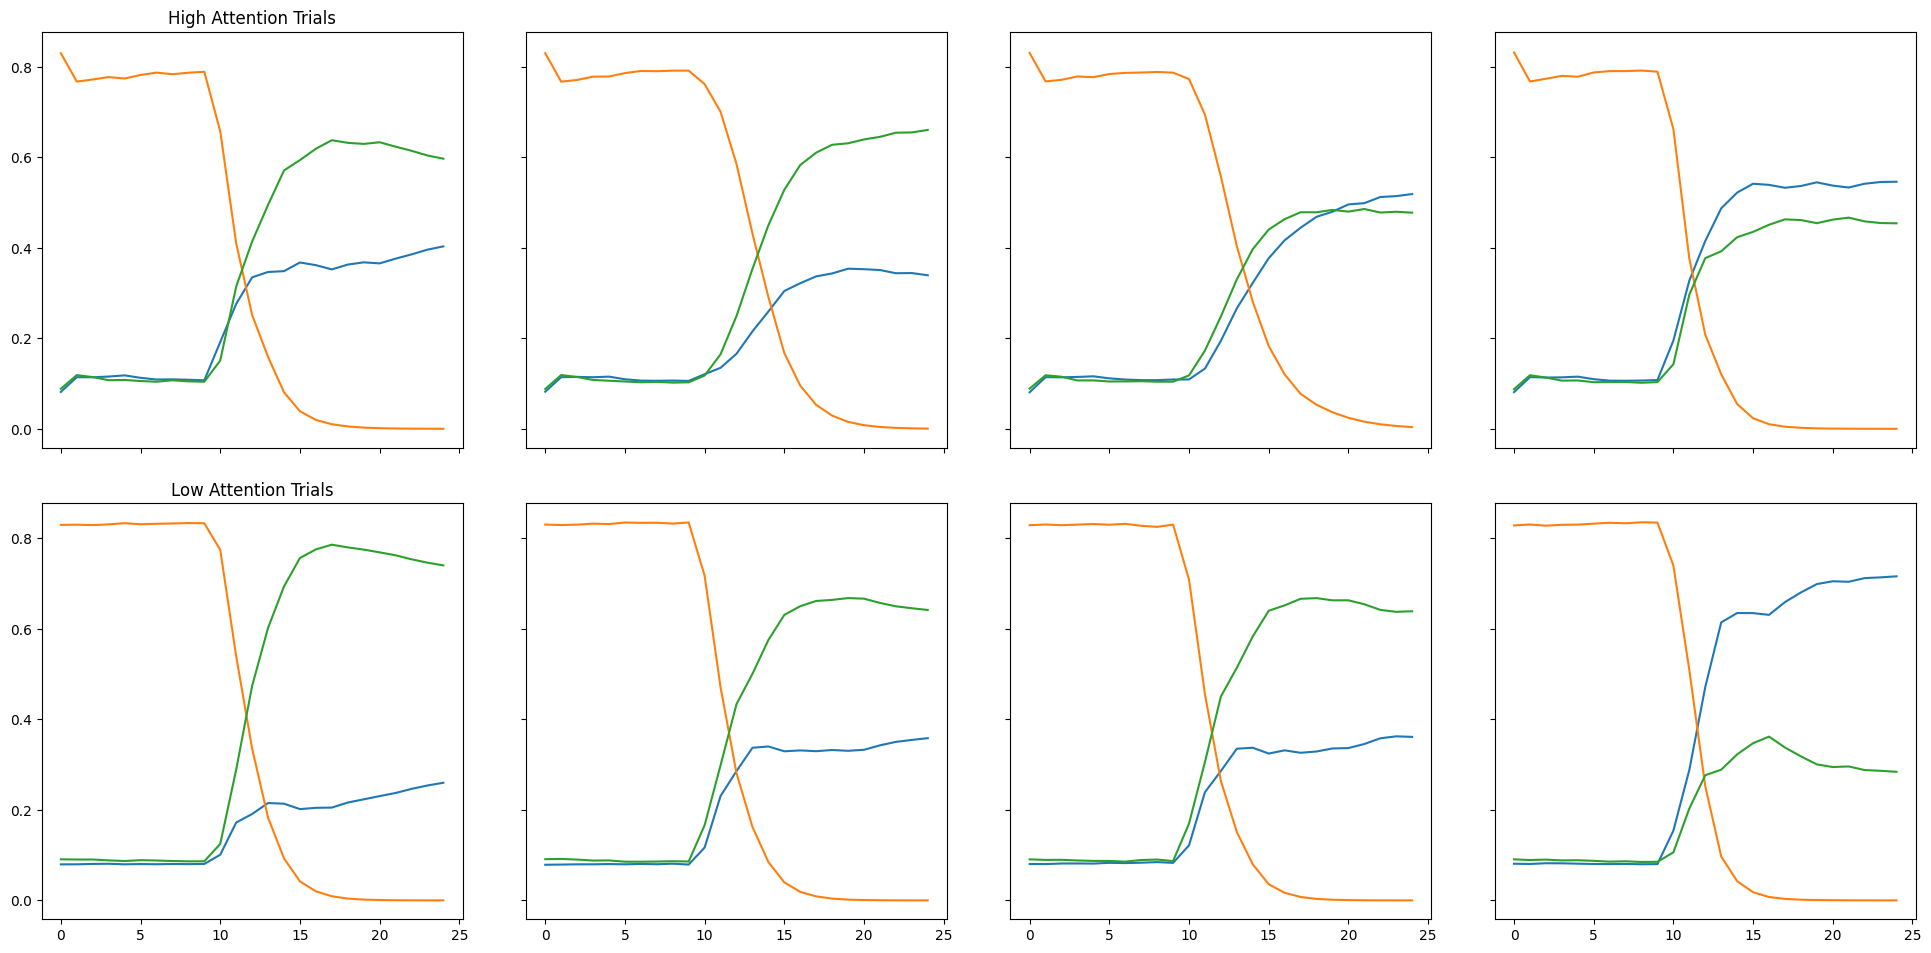

In [184]:
ATTENTION_LEVELS = [0,1]  # Binary attention, currently -> low (0) or high (1)
TRIALSPERANGLE = 10
ANGLEMAX = np.pi/2
ANGLEMIN = -np.pi/2
NUMANGLES = 8 #how many orientations each side can take
INPUT_DIMENSION = 3 #dimension of input. 
UNITS = 256 # Number of neurons in the dense layer
OUTPUT_SIZE = 3 # Number of output states
MAX_EPOCHS = 100 # Total epochs
BATCH_SIZE = 20000 # Trials per batch
ONECHOICE = False #whether makes one choice and sticks or changes mind
LOWATTVAL = 0
HIGHATTVAL = 1
FRAMERATE = 10 #(hz)
STIMULUSDURATION = 1.5 #length of the stimulus (seconds)
PRESTIMULUSDURATION = 1 #length of the pre stimulus (seconds)
TOTALFRAMES = int(FRAMERATE*(STIMULUSDURATION + PRESTIMULUSDURATION)) #total number of frames
LASTFRAME = TOTALFRAMES - 1 #Index of last frame
NOCHOICEVAL = 1
LEFTCHOICEVAL = 0  #Value output when choosing left bar
RIGHTCHOICEVAL = 2 #Value output when choosing right bar
PRESTIMULUSFRAME = int(PRESTIMULUSDURATION * FRAMERATE) - 1
STIMULUS_FRAME = PRESTIMULUSFRAME + 1
NUMDIFFBINS = 3 #should be about (numAngles-2)/2
ANGLE_DIMENSION = 2
MAXPROB = .95

run = main(ATTENTION_LEVELS, TRIALSPERANGLE, ANGLEMIN, ANGLEMAX, NUMANGLES,ONECHOICE,LOWATTVAL, HIGHATTVAL,TOTALFRAMES, STIMULUSDURATION, FRAMERATE, PRESTIMULUSFRAME,NOCHOICEVAL,LEFTCHOICEVAL, RIGHTCHOICEVAL, MAXPROB, STIMULUS_FRAME, NUMDIFFBINS,ANGLE_DIMENSION,INPUT_DIMENSION, UNITS, OUTPUT_SIZE,LASTFRAME, MAX_EPOCHS, BATCH_SIZE)



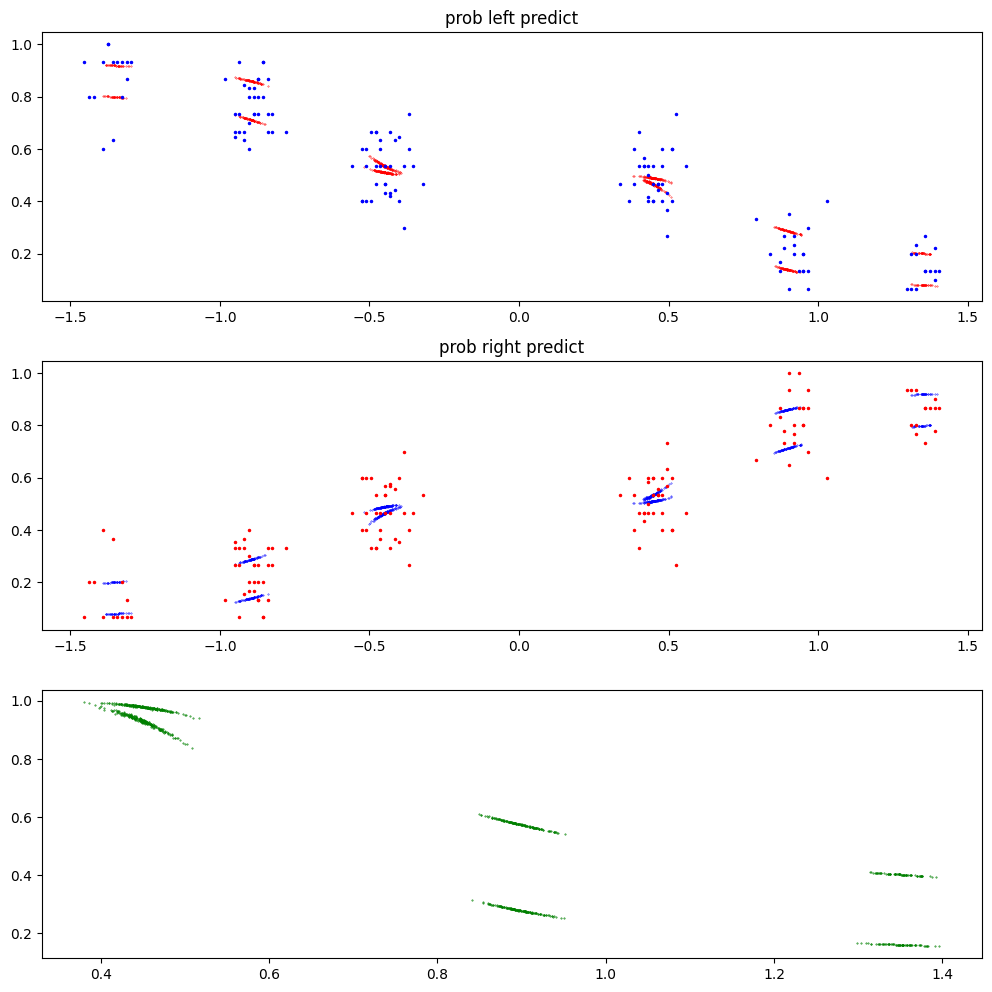

In [185]:
run.mod.plotPsychCurve(LEFTCHOICEVAL, RIGHTCHOICEVAL, STIMULUS_FRAME)

[175, 131, 211, 115] index low attention trials plotted
[99, 76, 206, 20] index of high attention trials plotted
[0, 2, 1, 0] difficulty low attention trials plotted
[0, 2, 1, 0] difficulty high attention trials plotted


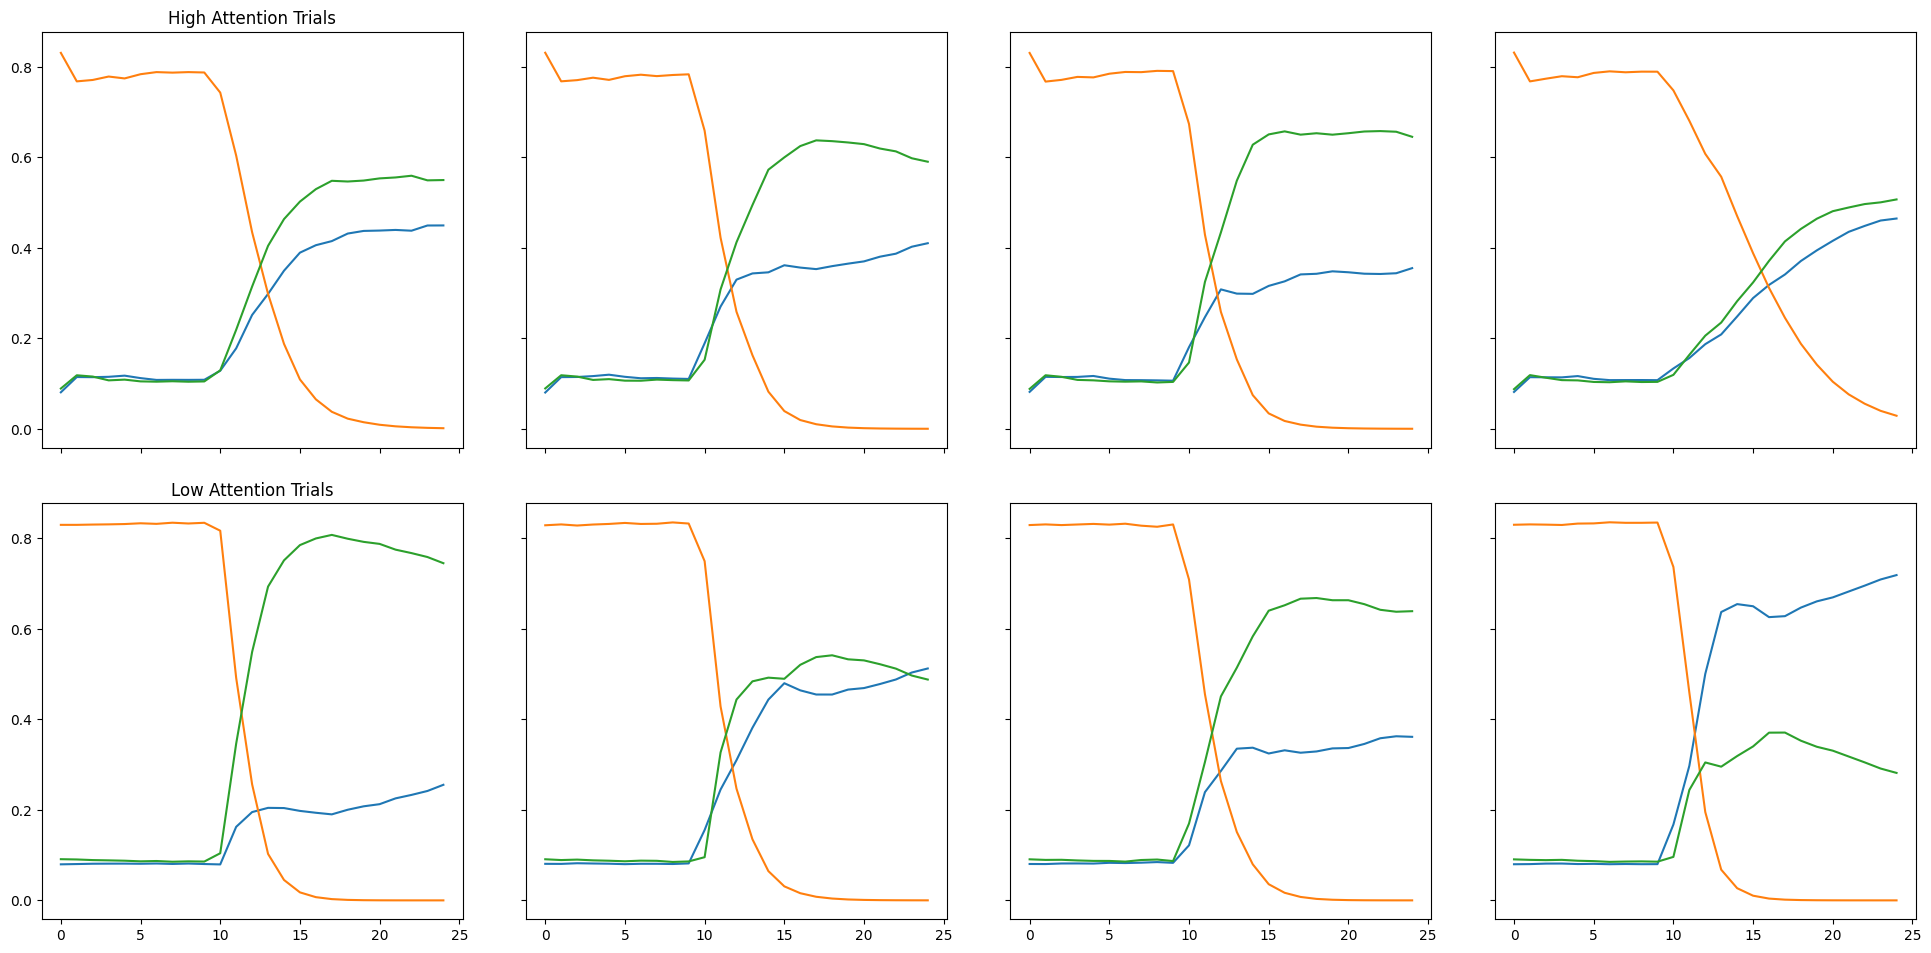

In [187]:
run.mod.plotTestResponse(NUMDIFFBINS)

In [188]:


'''rnn_layer_output = keras.Model(inputs=run.mod.model.inputs, outputs=run.mod.model.get_layer('rnn').output)

indicesAvailHighAtt = []
indicesAvailLowAtt = []


indexLowAtt = []
indexHighAtt = []

trialHighAttDifDict = {}

trialLowAttDifDict = {}

for index, number in enumerate(run.mod.testDifData):
    attentionLevel = run.mod.inputTestData[index][0][2]
    if attentionLevel == 0.0:
        if number not in trialLowAttDifDict:
            trialLowAttDifDict[number] = []
            trialLowAttDifDict[number].append(index)
            indicesAvailLowAtt.append(number)
        else:
            trialLowAttDifDict[number].append(index)
   

    elif attentionLevel == 1.0:
        if number not in trialHighAttDifDict:
            trialHighAttDifDict[number] = []
            trialHighAttDifDict[number].append(index)
            indicesAvailHighAtt.append(number)
        else:
            trialHighAttDifDict[number].append(index)
          
   

indicesAvailHighAtt = sorted(indicesAvailHighAtt)
indicesAvailLowAtt = sorted(indicesAvailLowAtt)

avgActivationsLowAttDict = {}
avgActivationsHighAttDict = {}

if len(indicesAvailLowAtt)>len(indicesAvailHighAtt):
    fig, ax = plt.subplots(1, 2, figsize = (20,10))
else:
    fig, ax = plt.subplots(1, 2, figsize = (20,10))

#for i in range(len(indicesAvailLowAtt)):
for i in range(1):

    maskLowAtt = np.zeros(run.mod.inputTestData.shape[0], dtype=bool)
    maskLowAtt[trialLowAttDifDict[indicesAvailLowAtt[i]]] = True

    trialsDataLowAtt = run.mod.inputTestData[maskLowAtt]
            
    # Get rnn layer activations for input X
    rnn_activations_lowAtt = rnn_layer_output.predict(trialsDataLowAtt)

    ''''''avgActivationsLowAtt = np.zeros(rnn_activations_lowAtt.shape[1:])
    c = 0
    for trial in rnn_activations_lowAtt:
        avgActivationsLowAtt += trial
        c+=1
    avgActivationsLowAtt = avgActivationsLowAtt/c
    avgActivationsLowAttDict[indicesAvailLowAtt[i]] = avgActivationsLowAtt''''''

    
            
    # Plotting the temporal dynamics of rnn layer units
    # Plotting the temporal dynamics of rnn layer units
    plotXListLowAtt = []
    plotYListLowAtt = []

    flatLowAtt = rnn_activations_lowAtt.reshape(-1, rnn_activations_lowAtt.shape[-1])
    t = 0
    for time in flatLowAtt:
        for node in time:
            plotXListLowAtt.append(t)
            plotYListLowAtt.append(node)
        t +=1 
   
ax[0].plot(plotXListLowAtt, plotYListLowAtt,'rx',alpha=0.1,markersize = 1.8)     

#for i in range(len(indicesAvailHighAtt)):
for i in range(1):

    maskHighAtt = np.zeros(run.mod.inputTestData.shape[0], dtype=bool)
    maskHighAtt[trialHighAttDifDict[indicesAvailHighAtt[i]]] = True

    trialsDataHighAtt = run.mod.inputTestData[maskHighAtt]
            
    # Get rnn layer activations for input X
    rnn_activations_highAtt = rnn_layer_output.predict(trialsDataHighAtt)
    
    avgActivationsHighAtt = np.zeros(rnn_activations_highAtt.shape[1:])
    c = 0
    for trial in rnn_activations_highAtt:
        avgActivationsHighAtt += trial
        c+=1
    avgActivationsHighAtt = avgActivationsHighAtt/c
    avgActivationsHighAttDict[indicesAvailHighAtt[i]] = avgActivationsHighAtt

    
            
    # Plotting the temporal dynamics of rnn layer units
    plotXList = []
    plotYList = []

    flat = rnn_activations_highAtt.reshape(-1, rnn_activations_highAtt.shape[-1])
    t = 0
    for time in flat:
       # for node in time:
        plotXList.append(t)
        plotYList.append(time)
        t +=1 
       # print(t)
   #     ax[0][1].plot(rnn_activations_highAtt[ :, unit_index], label=f'Unit {unit_index}')  # Assuming visualizing the first trial. The zero is the trial
   # ax[0][1].set_title("difficulty bin High Att Difficulty Bin "+ str(indicesAvailHighAtt[i]))

ax[1].plot(plotXList, plotYList,'rx',alpha=0.1,markersize = 1.8)    

  
plt.tight_layout()
plt.show()'''

'rnn_layer_output = keras.Model(inputs=run.mod.model.inputs, outputs=run.mod.model.get_layer(\'rnn\').output)\n\nindicesAvailHighAtt = []\nindicesAvailLowAtt = []\n\n\nindexLowAtt = []\nindexHighAtt = []\n\ntrialHighAttDifDict = {}\n\ntrialLowAttDifDict = {}\n\nfor index, number in enumerate(run.mod.testDifData):\n    attentionLevel = run.mod.inputTestData[index][0][2]\n    if attentionLevel == 0.0:\n        if number not in trialLowAttDifDict:\n            trialLowAttDifDict[number] = []\n            trialLowAttDifDict[number].append(index)\n            indicesAvailLowAtt.append(number)\n        else:\n            trialLowAttDifDict[number].append(index)\n   \n\n    elif attentionLevel == 1.0:\n        if number not in trialHighAttDifDict:\n            trialHighAttDifDict[number] = []\n            trialHighAttDifDict[number].append(index)\n            indicesAvailHighAtt.append(number)\n        else:\n            trialHighAttDifDict[number].append(index)\n          \n   \n\nindicesAva

In [189]:

'''from sklearn.decomposition import PCA



fig,ax = plt.subplots(1,2,figsize=(20, 10), sharex = True, sharey = True )
lengthTime = 25

for i in range(len(indicesAvailLowAtt)):
    pca = PCA(n_components=3)  # Choose the number of components as needed
    pca_result = pca.fit_transform(flatLowAtt)
    ax[0].scatter(range(lengthTime),pca_result[:lengthTime, 0], alpha=0.7,label=f'LowAtt Diff {indicesAvailLowAtt[i]}')
   # ax[0].scatter(range(25),pca_result[:, 1],  alpha=0.7,label=f'LowAtt Diff 2nd comp {indicesAvailLowAtt[i]}')
    #ax[0].scatter(range(25),pca_result[:, 2],  alpha=0.7)

    ax[0].set_title("Low Att")

for i in range(len(indicesAvailHighAtt)):
    pca = PCA(n_components=3)  # Choose the number of components as needed
    pca_result = pca.fit_transform(flat)
    ax[1].scatter(range(lengthTime),pca_result[:lengthTime, 0], alpha=0.7,label=f'HighAtt Diff {indicesAvailHighAtt[i]}')
    #ax[1].scatter(range(25),pca_result[:, 1],  alpha=0.7,label=f'HighAtt Diff 2nd comp {indicesAvailLowAtt[i]}')
    #ax[1].scatter(range(25),pca_result[:, 2],  alpha=0.7)

    ax[1].set_title("High ATT")    

ax[0].legend(loc='upper left')   
ax[1].legend(loc='upper left')   

plt.tight_layout()
plt.show()'''

'from sklearn.decomposition import PCA\n\n\n\nfig,ax = plt.subplots(1,2,figsize=(20, 10), sharex = True, sharey = True )\nlengthTime = 25\n\nfor i in range(len(indicesAvailLowAtt)):\n    pca = PCA(n_components=3)  # Choose the number of components as needed\n    pca_result = pca.fit_transform(flatLowAtt)\n    ax[0].scatter(range(lengthTime),pca_result[:lengthTime, 0], alpha=0.7,label=f\'LowAtt Diff {indicesAvailLowAtt[i]}\')\n   # ax[0].scatter(range(25),pca_result[:, 1],  alpha=0.7,label=f\'LowAtt Diff 2nd comp {indicesAvailLowAtt[i]}\')\n    #ax[0].scatter(range(25),pca_result[:, 2],  alpha=0.7)\n\n    ax[0].set_title("Low Att")\n\nfor i in range(len(indicesAvailHighAtt)):\n    pca = PCA(n_components=3)  # Choose the number of components as needed\n    pca_result = pca.fit_transform(flat)\n    ax[1].scatter(range(lengthTime),pca_result[:lengthTime, 0], alpha=0.7,label=f\'HighAtt Diff {indicesAvailHighAtt[i]}\')\n    #ax[1].scatter(range(25),pca_result[:, 1],  alpha=0.7,label=f\'HighA

In [190]:
rnn_layer_output = keras.Model(inputs=run.mod.model.inputs, outputs=run.mod.model.get_layer('rnn').output)



trialDict = {}

trialDict['left'] = {} 
trialDict['right'] = {}





for index, difBin in enumerate(run.mod.testDifData): #index is index of trial
    corCh = run.mod.testCorChData[index]

    if corCh == 0.0:#left

        if str(difBin) not in trialDict['left']:

            trialDict['left'][str(difBin)] = {}

            if run.mod.inputTestData[index][0][2] == 0.0:#low att

                if 'low' not in trialDict['left'][str(difBin)]:

                    trialDict['left'][str(difBin)]['low'] = []
                    trialDict['left'][str(difBin)]['low'].append(index)
                else:
                    trialDict['left'][str(difBin)]['low'].append(index)

            elif run.mod.inputTestData[index][0][2] == 1.0: #high att

                if 'high' not in trialDict['left'][str(difBin)]:

                    trialDict['left'][str(difBin)]['high'] = []
                    trialDict['left'][str(difBin)]['high'].append(index)
                else:
                    trialDict['left'][str(difBin)]['high'].append(index)
            else:
                print("error")
        else:

            if run.mod.inputTestData[index][0][2] == 0.0:#low att

                if 'low' not in trialDict['left'][str(difBin)]:
                    trialDict['left'][str(difBin)]['low'] = []  
                    trialDict['left'][str(difBin)]['low'].append(index)

            elif run.mod.inputTestData[index][0][2] == 1.0: #high att

                if 'high' not in trialDict['left'][str(difBin)]:
                    trialDict['left'][str(difBin)]['high'] = []
                    trialDict['left'][str(difBin)]['high'].append(index)
   

    elif corCh == 2.0:
        if str(difBin) not in trialDict['right']:

            trialDict['right'][str(difBin)] = {}

            if run.mod.inputTestData[index][0][2] == 0.0:#low att

                if 'low' not in trialDict['right'][str(difBin)]:

                    trialDict['right'][str(difBin)]['low'] = []
                    trialDict['right'][str(difBin)]['low'].append(index)
                else:
                    trialDict['right'][str(difBin)]['low'].append(index)

            elif run.mod.inputTestData[index][0][2] == 1.0: #high att

                if 'high' not in trialDict['right'][str(difBin)]:

                    trialDict['right'][str(difBin)]['high'] = []
                    trialDict['right'][str(difBin)]['high'].append(index)
                else:
                    trialDict['right'][str(difBin)]['high'].append(index)
            else:
                print("error")
        else:
            if run.mod.inputTestData[index][0][2] == 0.0:#low att

                if 'low' not in trialDict['right'][str(difBin)]:
                    trialDict['right'][str(difBin)]['low'] = []
                    trialDict['right'][str(difBin)]['low'].append(index)
                else:
                    trialDict['right'][str(difBin)]['low'].append(index)

            elif run.mod.inputTestData[index][0][2] == 1.0: #high att

                if 'high' not in trialDict['right'][str(difBin)]:
                    trialDict['right'][str(difBin)]['high'] = []
                    trialDict['right'][str(difBin)]['high'].append(index)
                else:
                    trialDict['right'][str(difBin)]['high'].append(index)
            else:
                print("error")
          
    else:
        print("error")
    



# Get rnn layer activations for input 
rnn_activations = rnn_layer_output.predict(run.mod.inputTestData)

   
            
# Plotting the temporal dynamics of rnn layer units
# Plotting the temporal dynamics of rnn layer units
plotXList = []
plotYList = []

flat = rnn_activations.reshape(-1, rnn_activations.shape[-1])



#plt.plot(range(len(flat)), flat,'rx',alpha=0.1,markersize = 1.8)     


#plt.show()

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


In [191]:
from sklearn.decomposition import PCA




lengthTime = 25


pca = PCA(n_components=UNITS)  # Choose the number of components as needed
pca_result = pca.fit_transform(flat)

pcaShaped = pca_result.reshape((len(run.mod.inputTestData), 25 , UNITS))

def avg(side,diff,att):
    averaged = np.zeros((25,UNITS))
    l = 0
    for index in trialDict[side][diff][att]:
        averaged += pcaShaped[index][:]
        l += 1
    averaged = averaged/l

    return averaged



rightPcaEasyHighAtt = avg('right','2.0','high')
leftPcaEasyHighAtt = avg('left','2.0','high')

rightPcaMedHighAtt = avg('right','1.0','high')
leftPcaMedHighAtt = avg('left','1.0','high')

rightPcaHardHighAtt = avg('right','0.0','high')
leftPcaHardHighAtt = avg('left','0.0','high')

rightPcaEasyLowAtt = avg('right','2.0','low')
leftPcaEasyLowAtt = avg('left','2.0','low')

rightPcaMedLowAtt = avg('right','1.0','low')
leftPcaMedLowAtt = avg('left','1.0','low')

rightPcaHardLowAtt = avg('right','0.0','low')
leftPcaHardLowAtt = avg('left','0.0','low')


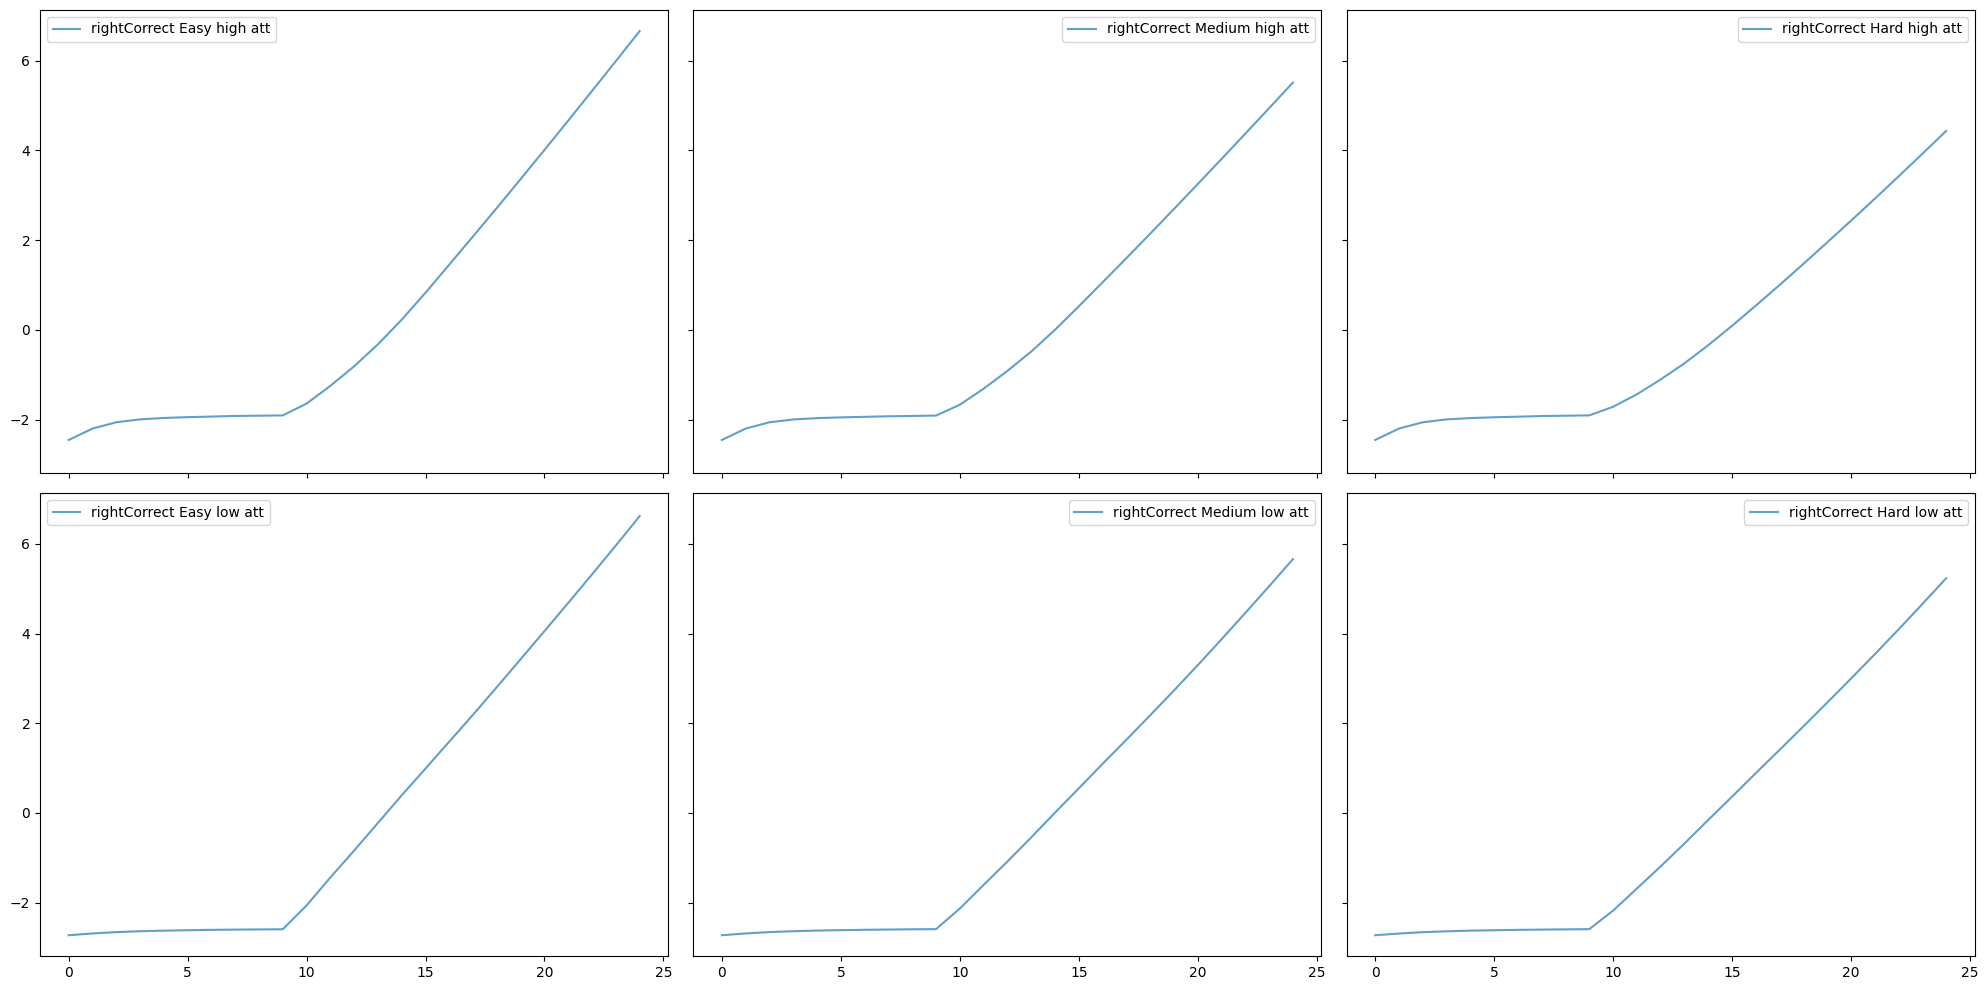

In [192]:
fig,ax = plt.subplots(2,3,figsize=(20, 10), sharex = True, sharey = True )
start = 0
stop = start+1


ax[0][0].plot(range(lengthTime),rightPcaEasyHighAtt[:,start:stop] , alpha=0.7, label = "rightCorrect Easy high att" )
ax[1][0].plot(range(lengthTime),rightPcaEasyLowAtt[:,start:stop], alpha=0.7,label = "rightCorrect Easy low att")

ax[0][1].plot(range(lengthTime),rightPcaMedHighAtt[:,start:stop] , alpha=0.7 ,label = "rightCorrect Medium high att")
ax[1][1].plot(range(lengthTime),rightPcaMedLowAtt[:,start:stop], alpha=0.7, label = "rightCorrect Medium low att")

ax[0][2].plot(range(lengthTime),rightPcaHardHighAtt[:,start:stop] , alpha=0.7 ,label = "rightCorrect Hard high att")
ax[1][2].plot(range(lengthTime),rightPcaHardLowAtt[:,start:stop], alpha=0.7,label = "rightCorrect Hard low att")

for i in range(2):
    for j in range(3):
        ax[i][j].legend() 


plt.tight_layout()
plt.show()

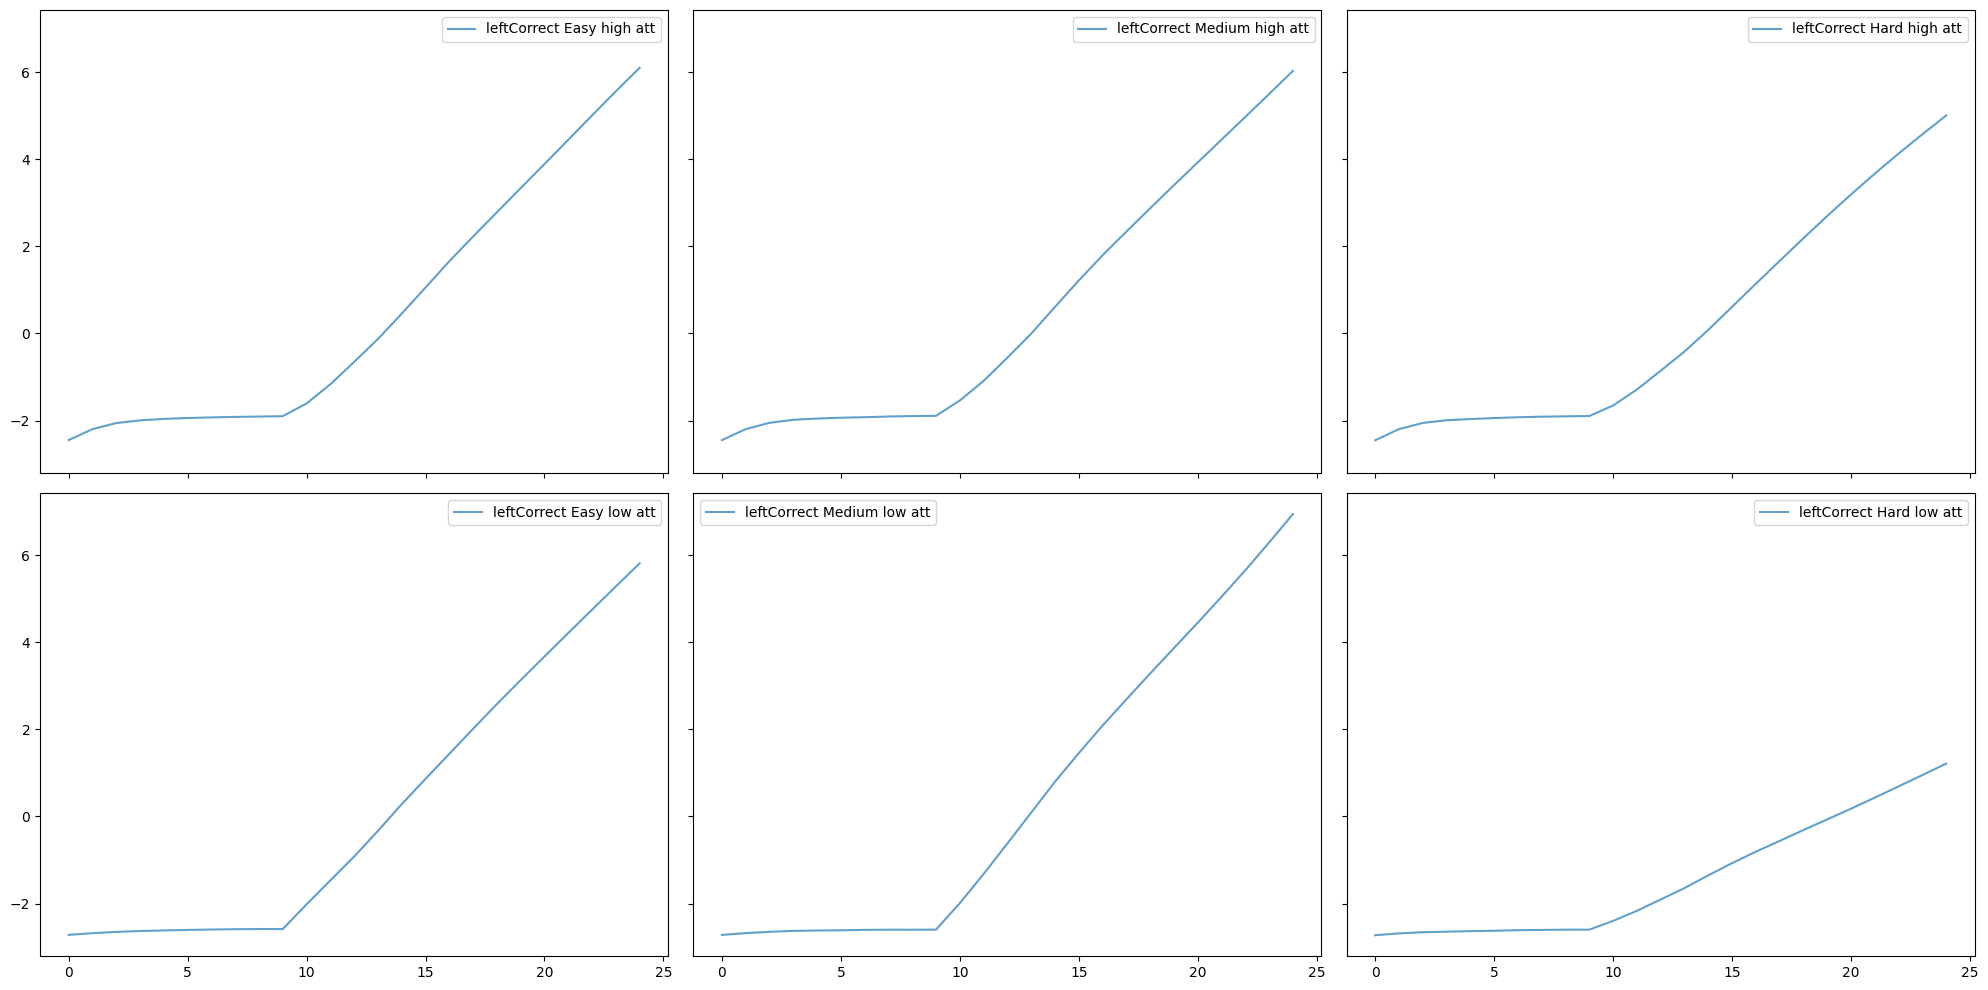

In [193]:
fig,ax = plt.subplots(2,3,figsize=(20, 10), sharex = True, sharey = True )
start = 0
stop = start+1


ax[0][0].plot(range(lengthTime),leftPcaEasyHighAtt[:,start:stop] , alpha=0.7, label = "leftCorrect Easy high att" )
ax[1][0].plot(range(lengthTime),leftPcaEasyLowAtt[:,start:stop], alpha=0.7,label = "leftCorrect Easy low att")

ax[0][1].plot(range(lengthTime),leftPcaMedHighAtt[:,start:stop] , alpha=0.7 ,label = "leftCorrect Medium high att")
ax[1][1].plot(range(lengthTime),leftPcaMedLowAtt[:,start:stop], alpha=0.7, label = "leftCorrect Medium low att")

ax[0][2].plot(range(lengthTime),leftPcaHardHighAtt[:,start:stop] , alpha=0.7 ,label = "leftCorrect Hard high att")
ax[1][2].plot(range(lengthTime),leftPcaHardLowAtt[:,start:stop], alpha=0.7,label = "leftCorrect Hard low att")

for i in range(2):
    for j in range(3):
        ax[i][j].legend() 


plt.tight_layout()
plt.show()

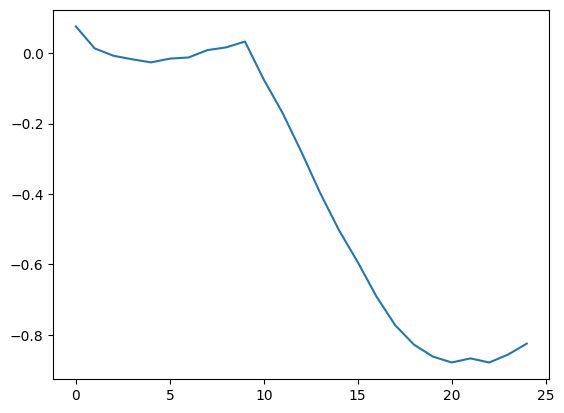

In [194]:
averagedL = np.zeros((25,UNITS))

averagedL += leftPcaEasyHighAtt
averagedL += leftPcaMedHighAtt
averagedL += leftPcaHardHighAtt
averagedL += leftPcaEasyLowAtt
averagedL += leftPcaMedLowAtt
averagedL += leftPcaHardLowAtt

averagedL = averagedL / 6

plt.plot(averagedL[:, 1:2])

plt.show()


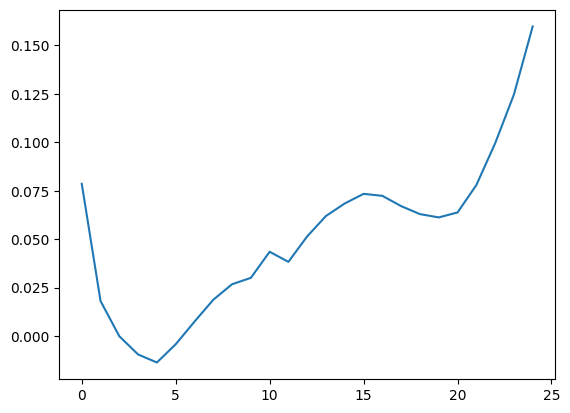

In [195]:
averagedR = np.zeros((int(TOTALFRAMES),UNITS))

averagedR += rightPcaEasyHighAtt
averagedR += rightPcaMedHighAtt
averagedR += rightPcaHardHighAtt
averagedR += rightPcaEasyLowAtt
averagedR += rightPcaMedLowAtt
averagedR += rightPcaHardLowAtt

averagedR = averagedR / 6

plt.plot(averagedR[:, 1:2])

plt.show()
